# Efficient frontier calculation

### seed collection

Seed values ensure that random number generation is reproducible and, to some extent, controlled. By setting a seed, the sequence of "random" numbers remains the same each time you run the code, which is useful for debugging, testing, and experimentation. While randomness still exists, setting the seed allows you to replay or share specific scenarios. To make it memorable, use your favorite numbers as seeds.

For fun, I collected some cool numbers for your entertainment — enjoy exploring the randomness!

- 1337 — Leet (elite) speak, popular in hacker culture.
- 007 — James Bond
- 008 - and his colleague
- 37 - the most frequently selected "random" number by humans
- 1701 — The registry number of the USS Enterprise from Star Trek.
- 1138 - George Lucas' directorial debut, appears in StarWars
- 101 -  Matrix, Neos appartman number.
- 6EQUJ5 - wow! signal - use it as hash(6EQUJ5)
- 88 - the speed required to go Back to the Future.
- 2187 - The number of Princess Leia's detention cell on Death Star.
- 1984 — A nod to George Orwell’s famous dystopian novel.
- 808 — Famous Roland TR-808 drum machine, iconic in electronic music.
- 42 — The original Hitchhiker’s Guide to the Galaxy number.
- 314 — A reference to Pi (3.14), cool for math enthusiasts.
- 1618 — The first few digits of the golden ratio (1.618033...).
- 12345 — the secret password from Spaceballs.
- 1967 - my year of birth
- 536 - the year of Late Antique Little Ice Age in Europe
- 1986 - Chernobyl Disaster
- 12 - twelve monkey, dirty dozen, blues
- 66 - order ended the Jedis in Star Wars
- 426 - LV-426 Acheron the moon Xenomorph is first encountered by humans
- 51 - Area 51 the popular landing site of UFOs
- 52 - Area 52 the ugly neighborhood (Dugway Proving Ground military testing facility).
- 0077 — Agent "Double-O Seven" but with extra flair.
- 404 — Annoying "not found" error code, you don't find it, debugging vibes.
- 1331 — A palindrome number, satisfying for symmetry lovers.
- 777 — Jackpot! For a bit of luck from the slot machines.
- 24601 — Jean Valjean's prisoner number in Les Misérables.
- 9000 — "I'm sorry, Dave. I'm afraid I can't do that." — HAL 9000 from 2001: A Space Odyssey.
- 8675309 — Jenny's number from the famous 1980s song "867-5309/Jenny."
- 1492 — The year Columbus sailed the ocean blue, a nod to historical events.
- 221 — Sherlock Holmes' iconic address at 221B Baker Street.
- 451 — Fahrenheit 451 by Ray Bradbury, representing censorship and dystopia.
- 1776 — The year of the U.S. Declaration of Independence.
- 1985 — The year Marty McFly travels back to in Back to the Future.
- 2015 - The future of Marty McFly back in the Future.
- 300 — The brave Spartans of 300, a movie reference.
- 1999 — Party like it’s 1999! A nod to Prince’s iconic song.       


### Python libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import datetime as dt
import yfinance as yf
from wordcloud import WordCloud
from sklearn.cluster import KMeans

### Functions

In [ ]:
def get_company_info(tickers_list):
    """
    Fetch company names and sectors for a given list of tickers from Yahoo Finance.

    Parameters:
    tickers_list (list): List of ticker symbols to fetch data for.

    Returns:
    pd.DataFrame: DataFrame with company names and sectors, with tickers as index.
    """
    company_names = []
    sectors = []
    industry = []
    revenues = []
    ebitda = []

    # Loop through each ticker to get the data
    for ticker in tickers_list:
        stock = yf.Ticker(ticker)
        info = stock.info
        company_names.append(info.get('shortName', 'N/A'))  # Get company name, 'N/A' if not available
        sectors.append(info.get('sector', 'N/A'))  # Get sector, 'N/A' if not available
        industry.append(info.get('industry', 'N/A'))
        revenues.append(f"{info.get('totalRevenue', 'N/A'):,.0f}" if info.get('totalRevenue', 'N/A') != 'N/A' else 'N/A')
        ebitda.append(f"{info.get('ebitda', 'N/A'):,.0f}" if info.get('ebitda', 'N/A') != 'N/A' else 'N/A')



    # Create a DataFrame with tickers as the index, and columns for company name and sector
    df = pd.DataFrame({
        'company_name': company_names,
        'industry': industry,
        'sector': sectors,
        'revenues': revenues,
        'ebitda': ebitda

    }, index=tickers_list)

    return df

In [ ]:
def stock_KPIs(dataframe, start_date, end_date):
  '''
    Explanation
    Daily Returns Calculation: The calculate_individual_returns function calculates returns per stock, leaving NaN where data is missing, so no artificial data is introduced.
    Mean Returns Calculation: Using mean(skipna=True) calculates the mean for each stock based only on existing data, ignoring NaN values.
    Covariance Matrix Calculation: The covariance matrix is calculated using pairwise deletion (min_periods=1), so each covariance value is based only on dates where both stocks have available data.
    '''
  filtered_df = dataframe.loc[start_date:end_date] # option to slice the data frame by date
  filtered_df = filtered_df.where(filtered_df > 0) # Replace zero or negative values with NaN (to handle cases where data might be invalid)
  filtered_df = filtered_df.ffill()  # Forward-fill only for zero or negative values that are transformed to NaN, Note: This still keeps original missing values as NaN

  def calculate_individual_returns(df):
        # Calculate daily log returns without filling NaNs (preserves missing data)
        return df.apply(lambda x: np.log(x / x.shift(1)))

  p_daily_returns = calculate_individual_returns(filtered_df) # still keeps the non-trading periods

  mean_returns = p_daily_returns.mean(skipna=True) * 252  # Annualized mean returns ignoring NaNs
  variance = p_daily_returns.var(skipna=True) * 252 # Annualized variance ignoring NaNs
  volatility = p_daily_returns.std(skipna=True) * np.sqrt(252)  # Annualized standard deviation
  cov_matrix_pairwise = p_daily_returns.cov(min_periods=1) * 252  # Annualized pairwise covariance matrix

  return {
      'data frame' : filtered_df,
      'variance': variance,
      'volatility': volatility,
      'mean_returns': mean_returns, # series for mean returns
      'cov_matrix': cov_matrix_pairwise
  }

In [ ]:
def create_metrics(stock_close, start_date, end_date):
  mean_returns = stock_KPIs(stock_close, start_date, end_date)['mean_returns'].rename('mean_returns')
  volatility = stock_KPIs(stock_close, start_date, end_date)['volatility'].rename('volatility')
  variance = stock_KPIs(stock_close, start_date, end_date)['variance'].rename('variance')
  cov_matrix = stock_KPIs(stock_close, start_date, end_date)['cov_matrix']
  return pd.DataFrame(
      {'mean_returns': mean_returns,
       'variance': np.diag(cov_matrix),
       'volatility': volatility
      }, index=mean_returns.index)

In [ ]:
def chart(x_min=0,
          x_max=2,
          y_min=-0.2,
          y_max=2,
          title='Efficient frontier',
          xlabel='Risk (Sigma)',
          ylabel='Return'):
    """
    Sets up the chart with specified axis limits, labels, and title.
    Returns the figure and axes objects for further plotting.
    """
    fig, ax = plt.subplots(figsize=(15, 6))

    # Set x and y axis limits
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Adding labels and title
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Hide top and right spines
    ax.spines[['top', 'right']].set_visible(False)

    # Turn off grid
    ax.grid(False)

    return fig, ax

In [ ]:
def portfolio_weights(cov_matrix, returns, col_name):
    '''
    This function calculates the portfolio weights from variance-covariance matrix and the mean returns.
    The method is also called: mean-variance optimization, where we product the inverse of the var-covariance matrix and the returns vector.
    The distribution of the product gives the optimized portfolio weights.
    '''
    # Calculate the values (weights before normalization)
    values = np.linalg.inv(cov_matrix).dot(returns)

    # Normalize the weights and convert them into a DataFrame
    weights = pd.Series(values / np.sum(values), index=cov_matrix.index, name=col_name)

    return weights


In [ ]:
def portfolio_stats(weights_series, returns_series, cov_matrix):
    '''
    This function is collection of mean, variance and volatility (sigma) calculation of a given portfolio.
    The calculation is based on matrices (weights as series, returns as series, and cov_matrix as data frame)
    The resulting informatin is stored in a dictionary.
    '''

    rounding = 5
    portfolio_mean = np.dot(weights_series, returns_series)
    portfolio_var = np.dot(weights_series.T, np.dot(cov_matrix, weights_series))
    portfolio_sigma = np.sqrt(portfolio_var)
    return {
        'mean': portfolio_mean.round(rounding),
        'var': portfolio_var.round(rounding),
        'sigma': portfolio_sigma.round(rounding)
    }

In [ ]:
def portfolio_mix(propx_range, var_x, var_t, cov_xt, mean_x, mean_t):
    '''
    This function calculates the of the various mix of two portfolios (x portfolio, and t portfolio).
    The mix is determined by a propx variable, where propx represents x portfolio weight, (1-propx) represents the t portfolio weight in the calculation.
    The function iterates through the propx_range and calculates the mean and sigma values for each of the propx_range elements.
    The resulting values are stored in a data frame (portfolio_mix_df)
    '''

    results = []

    for propx in propx_range:
        # Calculate sigma (portfolio risk)
        sigma = (propx**2 * var_x + (1 - propx)**2 * var_t + 2 * propx * (1 - propx) * cov_xt)**0.5

        # Calculate mean (portfolio expected return)
        mean = propx * mean_x + (1 - propx) * mean_t

        # Store the results as a tuple (propx, sigma, mean)
        results.append((propx, sigma, mean))

    # Convert results to a DataFrame for easy handling
    portfolio_mix_df = pd.DataFrame(results, columns=['propx', 'sigma', 'mean'])

    return portfolio_mix_df


In [ ]:
def rf_portfolio_mix(propx_range, sigma_y, mean_y, risk_free_rate):

    '''
    This function calculates the mean, sigma, of two portfolios, where the first portfolio
    is a risk free instrument (government bond, with a yield of risk_free_rate.
    the resulting data frame consist of different portfolio mixes, with each scenario with different weights.

    '''
    results = []

    for propx in propx_range:
        # Calculate sigma (portfolio risk)
        sigma = (1 - propx) * sigma_y

        # Calculate the portfolio return
        portfolio_return = propx * risk_free_rate + (1 - propx) * mean_y

        # Store the results as a tuple (propx, sigma, return)
        results.append((propx, sigma, portfolio_return))

    # Convert results to a DataFrame for easy handling
    rf_portfolio_mix_df = pd.DataFrame(results, columns=['propx', 'sigma', 'return'])

    return rf_portfolio_mix_df


In [ ]:
def portfolio_covar(weights_a, weights_b, sigma_a, sigma_b, cov_matrix):
    '''
    This function calculates the covariance and correlation of two portfilios (a portfolio, b portfolio)
    Based on weights, sigme, variance-covariance matrix, the function calculates the coveriance, and correlation data in a dictionary.
    '''
    rounding = 5
    covar = np.dot(weights_a.T, np.dot(cov_matrix, weights_b))

    # Calculate the correlation
    correlation = covar / (sigma_a * sigma_b)

    return {
        'covar': covar.round(rounding),
        'correlation': correlation.round(rounding)
    }

In [ ]:
def calculate_betas_using_TMP(portfolio_weights, cov_matrix, metrics, TMPmarket_var):
    # Calculate individual stock covariances with the market portfolio
    cov_with_market = cov_matrix @ portfolio_weights
    # Calculate betas using the historical TMP market variance
    betas = cov_with_market / TMPmarket_var
    # Add 'Beta' column to metrics DataFrame
    metrics['Beta'] = betas
    return metrics

In [ ]:
def calculate_betas(max_sharpe_weights, metrics, cov_matrix):
    """
    Calculate beta values for all stocks in the metrics DataFrame relative to the maximum Sharpe portfolio.

    Parameters:
    - max_sharpe_weights: DataFrame with weights for the stocks in the maximum Sharpe portfolio.
    - metrics: DataFrame containing returns and volatility data for all stocks.
    - cov_matrix: Full covariance matrix of all stocks.

    Returns:
    - A DataFrame with the original metrics and an added column for beta values for each stock.
    """
    # Extract portfolio stocks and weights from max_sharpe_weights
    portfolio_stocks = max_sharpe_weights.index
    portfolio_weights = max_sharpe_weights['weights']

    # Calculate the market portfolio variance using the maximum Sharpe portfolio weights
    filtered_cov_matrix = cov_matrix.loc[portfolio_stocks, portfolio_stocks]
    market_var = portfolio_weights.T @ filtered_cov_matrix.to_numpy() @ portfolio_weights

    # Initialize a Series to store beta values for all stocks
    beta_values = pd.Series(index=metrics.index, dtype=float)

    # Calculate beta for each stock in the entire metrics DataFrame
    for ticker in metrics.index:
        # Covariance of the stock with the market portfolio
        stock_cov_with_market = cov_matrix.loc[ticker, portfolio_stocks].to_numpy() @ portfolio_weights
        beta_values[ticker] = stock_cov_with_market / market_var

    # Add the beta column to the metrics DataFrame
    metrics['Beta'] = beta_values
    return metrics


### S&P500 review and split

In [ ]:
# define dates
start_date = '2010-01-01'
end_date = dt.datetime.today().strftime('%Y-%m-%d') # until today
history_start = start_date
history_end = '2022-12-31'
test_start = (pd.to_datetime(history_end) + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
test_end = (pd.to_datetime(test_start) + pd.offsets.YearEnd(0)).strftime('%Y-%m-%d')
forecast_start = (pd.to_datetime(test_end) + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
forecast_end = end_date  # Already in string format


In [ ]:
sp500_data = yf.download("^GSPC", start=start_date, end=end_date)



[*********************100%***********************]  1 of 1 completed


In [ ]:
sp500 = sp500_data['Close'].rename(columns={'^GSPC' : 'Close'})

In [ ]:

history_middle = pd.to_datetime(history_start) + (pd.to_datetime(history_end) - pd.to_datetime(history_start))/2


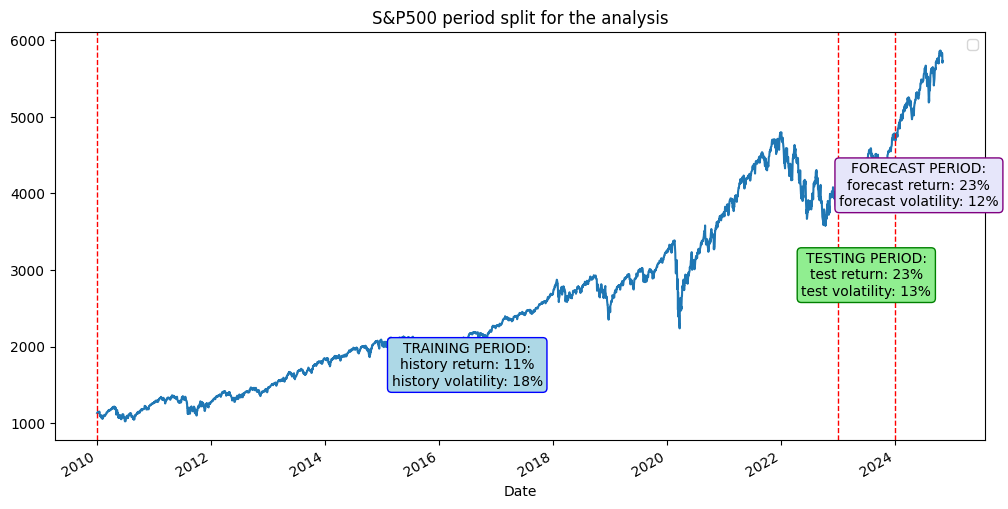

In [ ]:

sp500['daily_return'] = sp500['Close'].pct_change()

# Define periods
history_period = sp500.loc[history_start:history_end]
test_period = sp500.loc[history_end:test_end]
forecast_period = sp500.loc[forecast_start:forecast_end]

# Calculate annualized mean return and volatility for each period
history_mean = history_period['daily_return'].mean() * 252
history_volatility = history_period['daily_return'].std() * (252 ** 0.5)  # Annualize with sqrt(252)
test_mean = test_period['daily_return'].mean() * 252
test_volatility = test_period['daily_return'].std() * (252 ** 0.5)
forecast_mean = forecast_period['daily_return'].mean() * 252
forecast_volatility = forecast_period['daily_return'].std() * (252 ** 0.5)

# Define text boxes for each period
text_history = f'TRAINING PERIOD:\nhistory return: {history_mean:.0%}\nhistory volatility: {history_volatility:.0%}'
text_test = f'TESTING PERIOD:\ntest return: {test_mean:.0%}\ntest volatility: {test_volatility:.0%}'
text_forecast = f'FORECAST PERIOD:\nforecast return: {forecast_mean:.0%}\nforecast volatility: {forecast_volatility:.0%}'

# Calculate middle dates for text box positioning
history_middle = pd.to_datetime(history_start) + (pd.to_datetime(history_end) - pd.to_datetime(history_start)) / 2
test_middle = pd.to_datetime(history_end) + (pd.to_datetime(test_end) - pd.to_datetime(history_end)) / 2
forecast_middle = pd.to_datetime(forecast_start) + (pd.to_datetime(forecast_end) - pd.to_datetime(forecast_start)) / 2

# Plot S&P 500 data
fig, ax = plt.subplots(figsize=(12, 6))
sp500['Close'].plot(kind='line', ax=ax, label='S&P 500')

# Add text boxes for each period in the middle of the chart
ax.text(history_middle, sp500['Close'].max() * 0.3, text_history, fontsize=10,
        verticalalignment='center', horizontalalignment='center',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='blue', facecolor='lightblue'))

ax.text(test_middle, sp500['Close'].max() * 0.5, text_test, fontsize=10,
        verticalalignment='center', horizontalalignment='center',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='green', facecolor='lightgreen'))

ax.text(forecast_middle, sp500['Close'].max() * 0.7, text_forecast, fontsize=10,
        verticalalignment='center', horizontalalignment='center',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='purple', facecolor='lavender'))

# Important dates for vertical lines
important_dates = [history_start, history_end, test_end]
for date in important_dates:
    plt.axvline(x=date, color='red', linestyle='--', linewidth=1)

plt.title('S&P500 period split for the analysis')
# Display legend only for the main line plot
plt.legend([])


### Yahoo! downloads

In [3]:
pick = 'CEG' # make your random pick, if you know some tickers
yf.Ticker(pick).info

{'address1': '1310 Point Street',
 'city': 'Baltimore',
 'state': 'MD',
 'zip': '21231-3380',
 'country': 'United States',
 'phone': '833 883 0162',
 'website': 'https://www.constellationenergy.com',
 'industry': 'Utilities - Renewable',
 'industryKey': 'utilities-renewable',
 'industryDisp': 'Utilities - Renewable',
 'sector': 'Utilities',
 'sectorKey': 'utilities',
 'sectorDisp': 'Utilities',
 'longBusinessSummary': 'Constellation Energy Corporation generates and sells electricity in the United States. It operates through five segments: Mid-Atlantic, Midwest, New York, ERCOT, and Other Power Regions. The company sells natural gas, energy-related products, and sustainable solutions. It has approximately 33,094 megawatts of generating capacity consisting of nuclear, wind, solar, natural gas, and hydroelectric assets. It serves distribution utilities; municipalities; cooperatives; and commercial, industrial, governmental, and residential customers. The company was incorporated in 2021 a

In [ ]:
short_name = yf.Ticker(pick).info.get('shortName')
sector = yf.Ticker(pick).info.get('sector')
industry = yf.Ticker(pick).info.get('industry')
print(f'symbol: {pick}, company: {short_name}, industry: {industry}')

symbol: FLX, company: BINGEX LIMITED, industry: Integrated Freight & Logistics


In [ ]:
url = 'https://datahub.io/core/s-and-p-500-companies/r/constituents.csv'
sp500_tickers = pd.read_csv(url)

# Get the list of tickers, randomly by using sample
num_of_symbols =100
seed = 51
seed_description = 'ara 51 the ufo sight'
np.random.seed(seed)
tickers = sp500_tickers['Symbol'].sample(num_of_symbols, random_state=seed).tolist() # randome_state is the seed for the random choice

In [ ]:
companies_overview = get_company_info(tickers)
companies_overview.head()

,company_name,industry,sector,revenues,ebitda
CI,The Cigna Group,Healthcare Plans,Healthcare,"229,746,999,296","8,554,999,808"
PEP,"Pepsico, Inc.",Beverages - Non-Alcoholic,Consumer Defensive,"91,919,998,976","16,913,000,448"
PSX,Phillips 66,Oil & Gas Refining & Marketing,Energy,"147,738,001,408","5,571,999,744"
CMCSA,Comcast Corporation,Telecom Services,Communication Services,"123,069,997,056","37,285,998,592"
CEG,Constellation Energy Corporatio,Utilities - Renewable,Utilities,"23,544,000,512","5,585,999,872"


In [ ]:
df_sector = pd.DataFrame(companies_overview['sector'].value_counts()).reset_index()


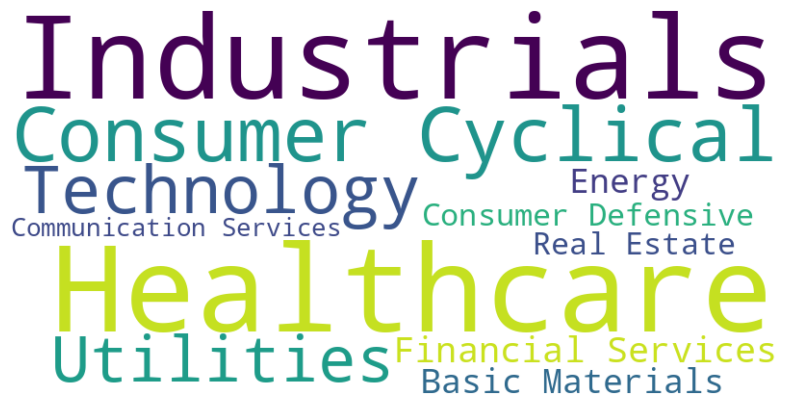

In [ ]:
# Create dictionary for word cloud
word_freq = dict(zip(df_sector['sector'], df_sector['count']))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display word cloud

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### stock prices

In [ ]:
#download stock prices
stocks = tickers
data = yf.download(stocks, start=start_date, end=end_date)

[*********************100%***********************]  100 of 100 completed


In [ ]:
data.head()

Price                      Adj Close                                     \
Ticker                             A      AAPL      ACGL       AES AMCR   
Date                                                                      
2010-01-04 00:00:00+00:00  20.053032  6.454503  7.994444  9.370145  NaN   
2010-01-05 00:00:00+00:00  19.835209  6.465663  7.967778  9.274179  NaN   
2010-01-06 00:00:00+00:00  19.764725  6.362820  7.933333  9.178217  NaN   
2010-01-07 00:00:00+00:00  19.739096  6.351057  7.886667  9.185071  NaN   
2010-01-08 00:00:00+00:00  19.732697  6.393279  7.871111  9.445545  NaN   

Price                                                                   \
Ticker                           AMT        APD         AZO         BA   
Date                                                                     
2010-01-04 00:00:00+00:00  33.184422  53.128712  158.029999  43.777538   
2010-01-05 00:00:00+00:00  33.734192  52.687904  156.710007  45.211346   
2010-01-06 00:00:00+00:00  33.909805  52.253464  155.240005  46.582806   
2010-01-07 00:00:00+00:00  33.818184  51.953186  157.300003  48.468552   
2010-01-08 00:00:00+00:00  33.886913  52.285423  155.279999  48.000996   

Price                                 ... Volume                         \
Ticker                          BALL  ...   UBER       UPS      VMC VST   
Date                                  ...                                 
2010-01-04 00:00:00+00:00  11.441868  ...    NaN   3897200  1128000 NaN   
2010-01-05 00:00:00+00:00  11.313260  ...    NaN   5966300   830300 NaN   
2010-01-06 00:00:00+00:00  11.335053  ...    NaN   5770200  1082900 NaN   
2010-01-07 00:00:00+00:00  11.308901  ...    NaN   5747000  1126900 NaN   
2010-01-08 00:00:00+00:00  11.350314  ...    NaN  13779300   702000 NaN   

Price                                                                    \
Ticker                          WBA     WELL       WMB     WST     WYNN   
Date                                                                      
2010-01-04 00:00:00+00:00   8171000  1426600   7020240  232800  4741400   
2010-01-05 00:00:00+00:00  10843200  1173300   7415481  245800  5644300   
2010-01-06 00:00:00+00:00   8945400  1061700  12157139  272800  2738800   
2010-01-07 00:00:00+00:00   5040700  1528800   6181305  130600  2388500   
2010-01-08 00:00:00+00:00   6139800  1089700   4703754  146200  1539800   

Price                               
Ticker                         XEL  
Date                                
2010-01-04 00:00:00+00:00  2670400  
2010-01-05 00:00:00+00:00  4321400  
2010-01-06 00:00:00+00:00  2164500  
2010-01-07 00:00:00+00:00  3041700  
2010-01-08 00:00:00+00:00  1599100  

[5 rows x 600 columns]

In [ ]:
data = data.reindex(columns=pd.MultiIndex.from_product([data.columns.levels[0], tickers])) # reorder the columns
data.sample(20)

Price                       Adj Close                                        \
                                   CI         PEP        PSX      CMCSA CEG   
Date                                                                          
2016-07-05 00:00:00+00:00  118.724831   83.782394  56.866379  26.976234 NaN   
2017-08-14 00:00:00+00:00  165.227951   95.417931  63.217995  35.347183 NaN   
2010-03-08 00:00:00+00:00   32.440945   42.004070        NaN   6.468036 NaN   
2013-07-17 00:00:00+00:00   70.631203   61.615456  39.193626  17.300671 NaN   
2013-03-04 00:00:00+00:00   54.389050   54.984741  44.139069  15.776348 NaN   
2015-02-19 00:00:00+00:00  108.766670   74.425156  54.543671  23.390083 NaN   
2021-03-25 00:00:00+00:00  227.283798  126.520309  71.786545  51.045074 NaN   
2016-04-25 00:00:00+00:00  131.370102   80.330078  63.647480  25.205482 NaN   
2013-04-16 00:00:00+00:00   62.126282   57.425350  39.838074  16.254267 NaN   
2010-04-08 00:00:00+00:00   34.176849   43.195774        NaN   6.822859 NaN   
2020-10-26 00:00:00+00:00  170.525360  123.228821  40.812889  39.503899 NaN   
2021-04-15 00:00:00+00:00  239.495865  128.948669  68.808502  49.311649 NaN   
2017-04-10 00:00:00+00:00  142.675980   90.086578  58.310135  31.649542 NaN   
2021-03-04 00:00:00+00:00  210.559601  116.734299  73.501961  48.896294 NaN   
2015-08-14 00:00:00+00:00  134.956451   75.866234  58.769276  24.011377 NaN   
2013-05-30 00:00:00+00:00   65.260658   58.301071  45.088882  16.073708 NaN   
2017-12-21 00:00:00+00:00  191.621307   97.097084  76.643318  34.571510 NaN   
2013-11-12 00:00:00+00:00   75.880127   62.346123  44.671734  18.608252 NaN   
2018-04-11 00:00:00+00:00  158.378326   89.890877  79.131996  28.705097 NaN   
2011-11-02 00:00:00+00:00   39.850567   42.768906        NaN   8.776596 NaN   

Price                                                                    \
                                 WYNN         PNC       STLD         SO   
Date                                                                      
2016-07-05 00:00:00+00:00   80.353821   59.916115  20.950201  37.986168   
2017-08-14 00:00:00+00:00  118.408958  102.313141  30.426657  35.647919   
2010-03-08 00:00:00+00:00   44.543316   36.977955  12.754280  16.966541   
2013-07-17 00:00:00+00:00  107.162407   52.481846  12.132857  27.535395   
2013-03-04 00:00:00+00:00   94.287254   44.763004  11.518361  27.105133   
2015-02-19 00:00:00+00:00  139.066208   67.675621  15.565121  30.497326   
2021-03-25 00:00:00+00:00  126.060799  154.333099  44.873550  53.494564   
2016-04-25 00:00:00+00:00   81.574242   66.665504  20.262327  34.115211   
2013-04-16 00:00:00+00:00  102.773514   45.958408  11.297038  28.971128   
2010-04-08 00:00:00+00:00   55.674297   42.684807  12.809719  17.574921   
2020-10-26 00:00:00+00:00   72.349648   96.641380  29.394402  51.745220   
2021-04-15 00:00:00+00:00  125.883659  153.389679  48.298328  56.205021   
2017-04-10 00:00:00+00:00  106.466934   91.545494  29.703365  35.979424   
2021-03-04 00:00:00+00:00  130.774567  150.479126  40.794994  50.034584   
2015-08-14 00:00:00+00:00   81.595490   72.866745  17.132212  31.342978   
2013-05-30 00:00:00+00:00  112.548637   51.696995  11.986164  26.847921   
2017-12-21 00:00:00+00:00  156.173019  114.963326  37.493103  37.119953   
2013-11-12 00:00:00+00:00  138.209915   53.262074  14.938534  25.780874   
2018-04-11 00:00:00+00:00  167.171890  118.045982  38.228073  33.794571   
2011-11-02 00:00:00+00:00   93.848312   35.921295   9.327802  24.406534   

Price                                  ...      Volume                      \
                                 MKTX  ...         KMI       BAX      ROST   
Date                                   ...                                   
2016-07-05 00:00:00+00:00  135.223343  ...  13259700.0   3980800   1577300   
2017-08-14 00:00:00+00:00  182.280640  ...   8107100.0   1976400   3457100   
2010-03-08 00:00:00+00:00   13.049730  ...         NaN   4114635  

In [ ]:
stock_close = data['Adj Close']
stock_close = stock_close.dropna(axis=1, how='any')
stock_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3734 entries, 2010-01-04 00:00:00+00:00 to 2024-11-01 00:00:00+00:00
Data columns (total 83 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CI      3734 non-null   float64
 1   PEP     3734 non-null   float64
 2   CMCSA   3734 non-null   float64
 3   WYNN    3734 non-null   float64
 4   PNC     3734 non-null   float64
 5   STLD    3734 non-null   float64
 6   SO      3734 non-null   float64
 7   MKTX    3734 non-null   float64
 8   MRO     3734 non-null   float64
 9   BALL    3734 non-null   float64
 10  MCHP    3734 non-null   float64
 11  AZO     3734 non-null   float64
 12  IEX     3734 non-null   float64
 13  FICO    3734 non-null   float64
 14  XEL     3734 non-null   float64
 15  GIS     3734 non-null   float64
 16  PCAR    3734 non-null   float64
 17  FCX     3734 non-null   float64
 18  NRG     3734 non-null   float64
 19  BDX     3734 non-null   float64
 20  POOL    3734 non-null   fl

### stocks - returns and volatility

- The example assumes that we already have a variance-covariance matrix, a vector of expected returns (mean returns, or mean).
- Calculation of such metrics is discussed in another workbook.

In [ ]:
metrics_history = create_metrics(stock_close, history_start, history_end)
metrics_history.sort_values(by='mean_returns',ascending=False)

,mean_returns,variance,volatility
DPZ,0.298073,0.089148,0.298577
FICO,0.256742,0.118087,0.343638
MKTX,0.239344,0.107431,0.327767
ORLY,0.237865,0.068587,0.261890
MOH,0.233957,0.167680,0.409488
...,...,...,...
PARA,0.030163,0.157328,0.396646
WBA,0.026967,0.080293,0.283360
FCX,0.014937,0.261902,0.511764
DVN,0.008086,0.224581,0.473900


In [ ]:
metrics_history.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83 entries, CI to DPZ
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mean_returns  83 non-null     float64
 1   variance      83 non-null     float64
 2   volatility    83 non-null     float64
dtypes: float64(3)
memory usage: 4.6+ KB


In [ ]:
cov_matrix_history = stock_KPIs(stock_close, history_start, history_end)['cov_matrix']
cov_matrix_history

,CI,PEP,CMCSA,WYNN,PNC,STLD,SO,MKTX,MRO,BALL,...,F,BAX,ROST,ORLY,MTB,GRMN,APD,WELL,A,DPZ
CI,0.083827,0.018887,0.028086,0.046737,0.038730,0.046006,0.017375,0.026468,0.047067,0.024482,...,0.037762,0.026491,0.032902,0.025168,0.037358,0.025947,0.030084,0.031465,0.037818,0.021904
PEP,0.018887,0.030459,0.019724,0.020562,0.020431,0.019988,0.019826,0.019598,0.017879,0.019268,...,0.019164,0.017264,0.018177,0.018556,0.018931,0.017327,0.020445,0.021590,0.020369,0.013618
CMCSA,0.028086,0.019724,0.060147,0.045373,0.036229,0.037674,0.016104,0.023454,0.039810,0.024022,...,0.033813,0.022671,0.030282,0.024900,0.034079,0.025902,0.027542,0.029669,0.032309,0.021759
WYNN,0.046737,0.020562,0.045373,0.222694,0.062805,0.078597,0.016357,0.034071,0.091051,0.032983,...,0.076477,0.029390,0.057740,0.034278,0.063804,0.046426,0.045667,0.055288,0.054301,0.035180
PNC,0.038730,0.020431,0.036229,0.062805,0.080415,0.062187,0.019572,0.030725,0.068027,0.030349,...,0.055203,0.026794,0.041840,0.029000,0.068718,0.034722,0.037059,0.038547,0.043131,0.022512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GRMN,0.025947,0.017327,0.025902,0.046426,0.034722,0.041979,0.015427,0.026916,0.041783,0.025420,...,0.039716,0.020827,0.030841,0.023632,0.032913,0.076473,0.029161,0.025748,0.036825,0.020388
APD,0.030084,0.020445,0.027542,0.045667,0.037059,0.045984,0.019923,0.028152,0.044405,0.029729,...,0.037933,0.025390,0.027488,0.023676,0.034863,0.029161,0.056889,0.028769,0.039802,0.020175
WELL,0.031465,0.021590,0.029669,0.055288,0.038547,0.041377,0.027826,0.023276,0.044705,0.025197,...,0.039614,0.020170,0.039413,0.024280,0.038156,0.025748,0.028769,0.089616,0.028823,0.018619
A,0.037818,0.020369,0.032309,0.054301,0.043131,0.052134,0.017218,0.037986,0.050205,0.034828,...,0.044381,0.031917,0.032545,0.026701,0.040075,0.036825,0.039802,0.028823,0.083618,0.028867


In [ ]:
cov_matrix_history.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83 entries, CI to DPZ
Data columns (total 83 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CI      83 non-null     float64
 1   PEP     83 non-null     float64
 2   CMCSA   83 non-null     float64
 3   WYNN    83 non-null     float64
 4   PNC     83 non-null     float64
 5   STLD    83 non-null     float64
 6   SO      83 non-null     float64
 7   MKTX    83 non-null     float64
 8   MRO     83 non-null     float64
 9   BALL    83 non-null     float64
 10  MCHP    83 non-null     float64
 11  AZO     83 non-null     float64
 12  IEX     83 non-null     float64
 13  FICO    83 non-null     float64
 14  XEL     83 non-null     float64
 15  GIS     83 non-null     float64
 16  PCAR    83 non-null     float64
 17  FCX     83 non-null     float64
 18  NRG     83 non-null     float64
 19  BDX     83 non-null     float64
 20  POOL    83 non-null     float64
 21  PH      83 non-null     float64
 22  EXR    

### portfolios
- portfolio x: based on individual stock returns
- portfolio y: based on individual stock returns reduced by the risk free rate
- portfolio t: based on individual stock returns reduced by constant

constant represent the kind of expectation of the investor (however, from math point of view this is just a third point on the plane to have the calculation done. It can be any number around the portfolio return ranges)


In [ ]:
#define risk_free_rate and
risk_free_rate = 0.03
constant = 0.195

#define the range of calculation (proportion of x portfolio)
propx_range = np.linspace(-0.5, 2, 100)

In [ ]:
# defining portolio weights
x_weights = portfolio_weights(cov_matrix_history, metrics_history['mean_returns'], 'x_weights')
y_weights = portfolio_weights(cov_matrix_history, metrics_history['mean_returns']-risk_free_rate, 'y_weights')
t_weights = portfolio_weights(cov_matrix_history, metrics_history['mean_returns']-constant, 't_weights')

In [ ]:
x_stats = portfolio_stats(x_weights, metrics_history['mean_returns'], cov_matrix_history)
y_stats = portfolio_stats(y_weights, metrics_history['mean_returns'], cov_matrix_history)
t_stats = portfolio_stats(t_weights, metrics_history['mean_returns'], cov_matrix_history)

In [ ]:
xy_covar = portfolio_covar(x_weights, y_weights, x_stats['sigma'], y_stats['sigma'], cov_matrix_history )
xt_covar = portfolio_covar(x_weights, t_weights, x_stats['sigma'], t_stats['sigma'], cov_matrix_history )

In [ ]:
portfolio_mix_df = portfolio_mix(propx_range, x_stats['var'], t_stats['var'], xt_covar['covar'], x_stats['mean'], t_stats['mean'])

In [ ]:
rf_portfolio_mix_df = rf_portfolio_mix(propx_range, y_stats['sigma'], y_stats['mean'], risk_free_rate)

In [ ]:
y_stats

{'mean': 0.8104, 'var': 0.1412, 'sigma': 0.37577}

### risk and return scatter plot
The following chart illustrates the relationship between risk, represented by sigma (or volatility), and returns (mean). In financial theory, stocks are often evaluated by comparing their potential returns to the risks associated with them. A higher risk is generally associated with the potential for higher returns, and this chart visually demonstrates this connection.

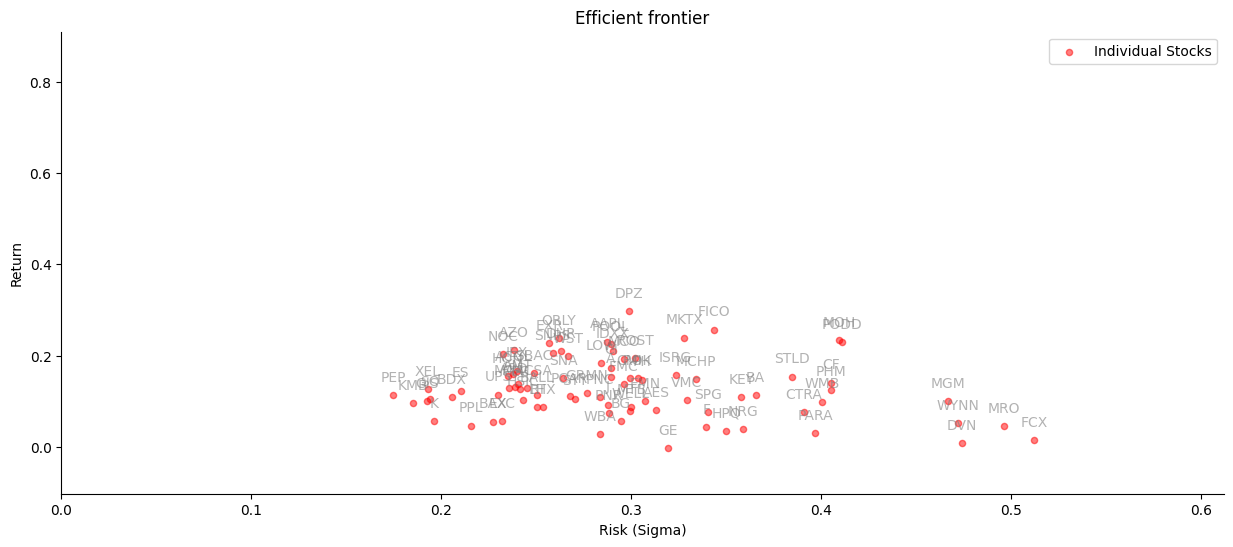

In [ ]:
fig, ax = chart(
    y_max = max(metrics_history['mean_returns'].max(), y_stats['mean']) + 0.1,
    y_min = metrics_history['mean_returns'].min() - 0.1,
    x_max = metrics_history['volatility'].max() + 0.1,
    x_min = 0) # pre-defined chart

# Individual stocks
ax.scatter(metrics_history['volatility'], metrics_history['mean_returns'], color='red', alpha = 0.5, s=20, label='Individual Stocks')

for i, ticker in enumerate(metrics_history.index):
    ax.annotate(
        ticker,
        (metrics_history['volatility'].iloc[i], metrics_history['mean_returns'].iloc[i]),
        textcoords="offset points",
        xytext=(0, 10),
        alpha=0.6,
        color='grey',
        ha='center'
    )

# Update the legend
ax.legend()

# Redraw the figure to update the display
plt.show()

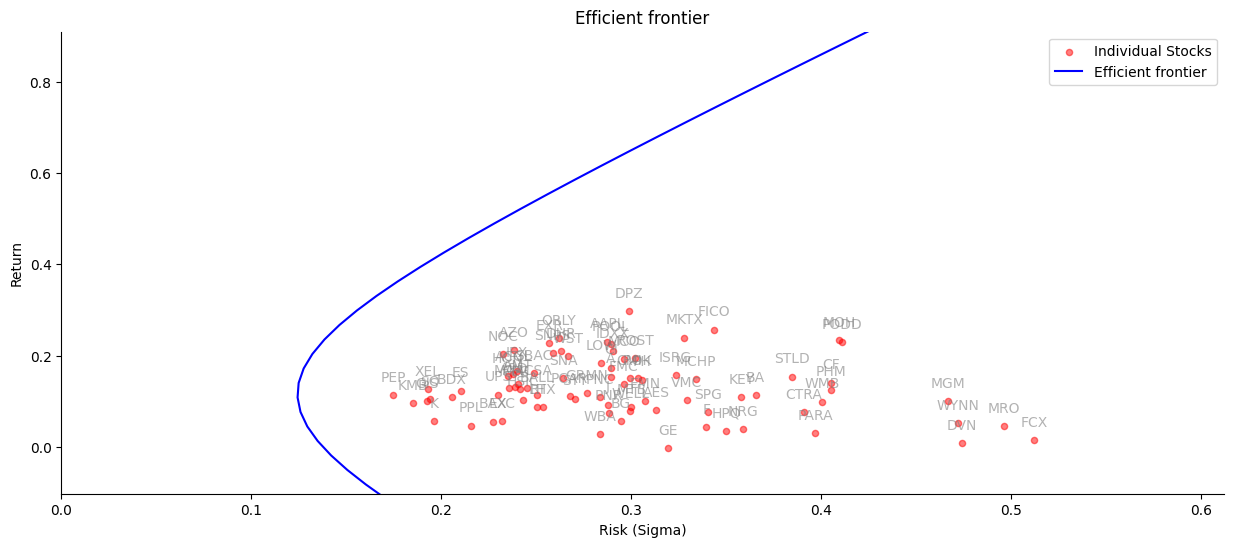

In [ ]:
fig, ax = chart(
    y_max = max(metrics_history['mean_returns'].max(), y_stats['mean']) + 0.1,
    y_min = metrics_history['mean_returns'].min() - 0.1,
    x_max = metrics_history['volatility'].max() + 0.1,
    x_min = 0) # pre-defined chart

# Individual stocks
ax.scatter(metrics_history['volatility'], metrics_history['mean_returns'], color='red', alpha = 0.5, s=20, label='Individual Stocks')

for i, ticker in enumerate(metrics_history.index):
    ax.annotate(
        ticker,
        (metrics_history['volatility'].iloc[i], metrics_history['mean_returns'].iloc[i]),
        textcoords="offset points",
        xytext=(0, 10),
        alpha=0.6,
        color='grey',
        ha='center'
    )


plt.plot(portfolio_mix_df['sigma'], portfolio_mix_df['mean'], label="Efficient frontier", color='blue')

# Update the legend
ax.legend()

# Redraw the figure to update the display
plt.show()

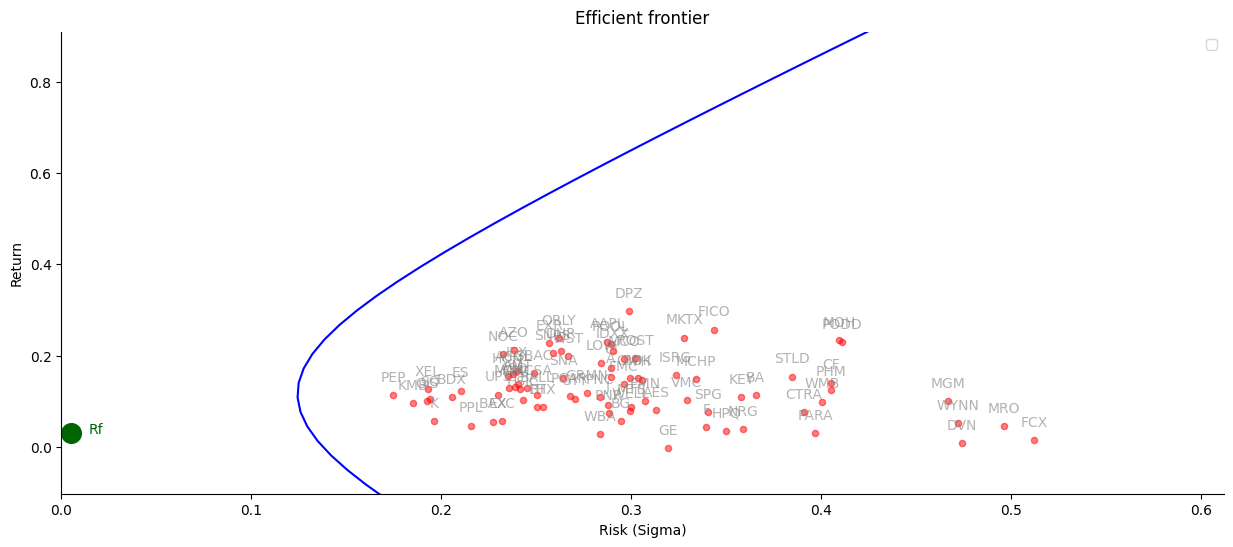

In [ ]:
fig, ax = chart(
    y_max = max(metrics_history['mean_returns'].max(), y_stats['mean']) + 0.1,
    y_min = metrics_history['mean_returns'].min() - 0.1,
    x_max = metrics_history['volatility'].max() + 0.1,
    x_min = 0) # pre-defined chart

# Individual stocks
ax.scatter(metrics_history['volatility'], metrics_history['mean_returns'], color='red', alpha = 0.5, s=20, label='Individual Stocks')

for i, ticker in enumerate(metrics_history.index):
    ax.annotate(
        ticker,
        (metrics_history['volatility'].iloc[i], metrics_history['mean_returns'].iloc[i]),
        textcoords="offset points",
        xytext=(0, 10),
        alpha=0.6,
        color='grey',
        ha='center'
    )

plt.plot(portfolio_mix_df['sigma'], portfolio_mix_df['mean'], label="Efficient frontier", color='blue')

# Risk-free rate
ax.scatter(
    0.005,
    risk_free_rate,
    color='darkgreen',
    marker='o',
    s=200,
    label='Risk-Free Rate'
)

ax.annotate(
    'Rf',
    (0, risk_free_rate),
    textcoords="offset points",
    xytext=(25, 0),
    ha='center',
    color='darkgreen'
)

# Update the legend
ax.legend('')

# Redraw the figure to update the display
plt.show()

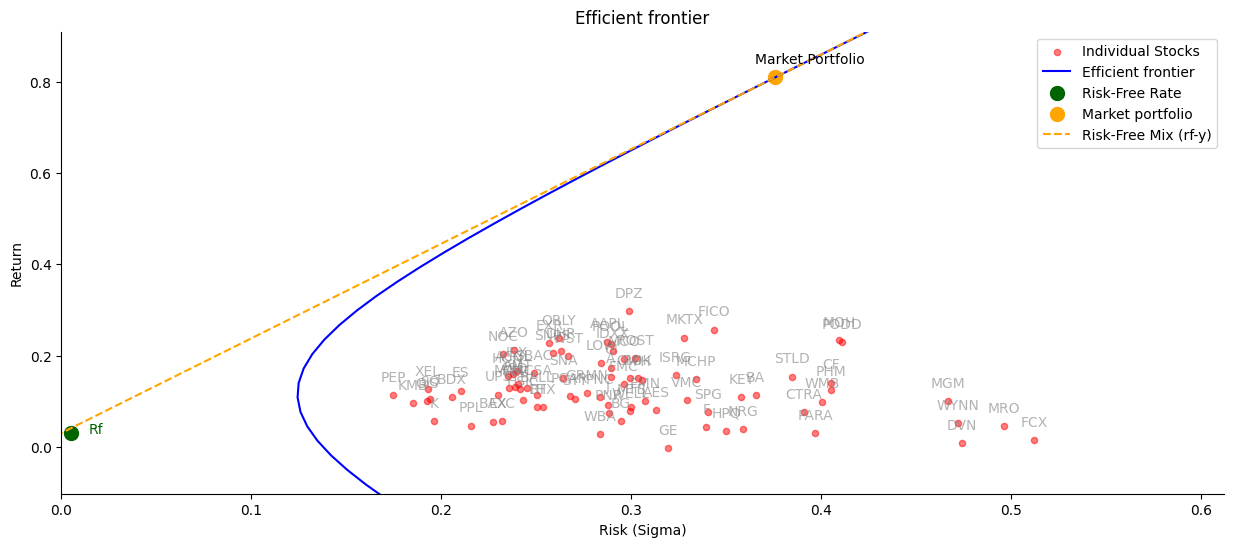

In [ ]:
fig, ax = chart(
    y_max = max(metrics_history['mean_returns'].max(), y_stats['mean']) + 0.1,
    y_min = metrics_history['mean_returns'].min() - 0.1,
    x_max = metrics_history['volatility'].max() + 0.1,
    x_min = 0) # pre-defined chart

# Individual stocks
ax.scatter(metrics_history['volatility'], metrics_history['mean_returns'], color='red', alpha = 0.5, s=20, label='Individual Stocks')

for i, ticker in enumerate(metrics_history.index):
    ax.annotate(
        ticker,
        (metrics_history['volatility'].iloc[i], metrics_history['mean_returns'].iloc[i]),
        textcoords="offset points",
        xytext=(0, 10),
        alpha=0.6,
        color='grey',
        ha='center'
    )

plt.plot(portfolio_mix_df['sigma'], portfolio_mix_df['mean'], label="Efficient frontier", color='blue')

ax.scatter(
    0.005,
    risk_free_rate,
    color='darkgreen',
    marker='o',
    s=100,
    label='Risk-Free Rate'
)


ax.scatter(
    y_stats['sigma'],
    y_stats['mean'],
    color='orange',
    marker='o',
    s=100,
    label='Market portfolio'
)

ax.annotate(
    'Rf',
    (0, risk_free_rate),
    textcoords="offset points",
    xytext=(25, 0),
    ha='center',
    color='darkgreen'
)

ax.annotate(
    'Market Portfolio',
    (y_stats['sigma'], y_stats['mean']),
    textcoords="offset points",
    xytext=(25, 10),
    ha='center',
    color='black'
)

plt.plot(rf_portfolio_mix_df['sigma'], rf_portfolio_mix_df['return'], label="Risk-Free Mix (rf-y)", color='orange', linestyle='--')
# Update the legend
ax.legend()

# Redraw the figure to update the display
plt.show()

### CAPM model (Professor's betas)

In [ ]:
sharpe_weights = pd.DataFrame(y_weights.rename('weights'))
beta_df = calculate_betas(sharpe_weights, metrics_history, cov_matrix_history)
mp = {'mean_returns': y_stats['mean'], 'variance': y_stats['var'], 'volatility': y_stats['sigma'], 'Beta': 1}
beta_mp_df = beta_df.copy()
beta_mp_df.loc['market portfolio'] = mp
beta_mp_df

,mean_returns,variance,volatility,Beta
CI,0.173293,0.083827,0.289530,0.183614
PEP,0.112557,0.030459,0.174525,0.105787
CMCSA,0.128136,0.060147,0.245250,0.125750
WYNN,0.052051,0.222694,0.471904,0.028256
PNC,0.108317,0.080415,0.283576,0.100354
...,...,...,...,...
APD,0.131995,0.056889,0.238514,0.130696
WELL,0.078561,0.089616,0.299360,0.062226
A,0.153897,0.083618,0.289168,0.158760
DPZ,0.298073,0.089148,0.298577,0.343505


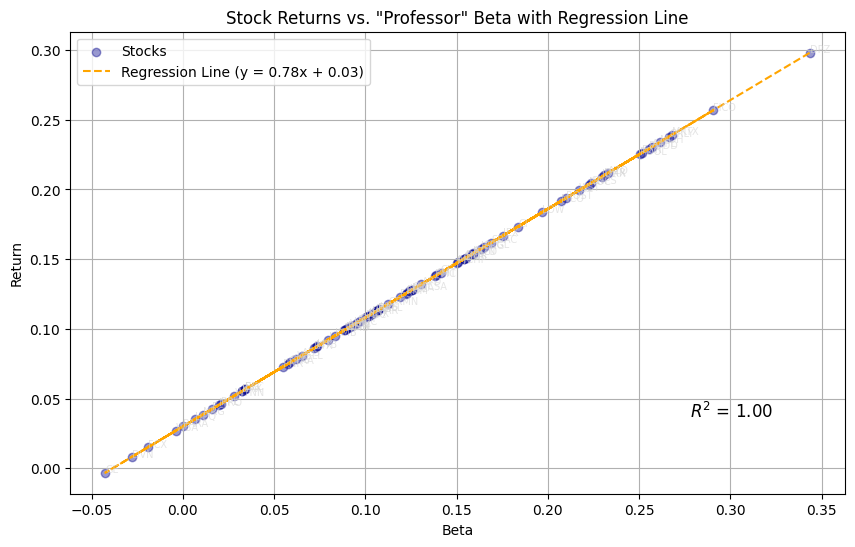

In [ ]:
from scipy.stats import linregress

# Extract Beta and Return values for regression
x = beta_df['Beta']
y = beta_df['mean_returns']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate the regression line
regression_line = slope * x + intercept


# Plot the scatter plot and regression line
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='darkblue', alpha=0.4, label='Stocks')
plt.plot(x, regression_line, color='orange', linestyle='--', label=f'Regression Line (y = {slope:.2f}x + {intercept:.2f})')


# Add labels for each stock
for ticker in beta_df.index:
    plt.text(beta_df.loc[ticker, 'Beta'], beta_df.loc[ticker, 'mean_returns'], ticker, color='lightgrey', fontsize=7, alpha=0.6, ha='left')

# Display R-squared value on the plot
plt.text(0.8, 0.2, f'$R^2$ = {r_value**2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# Set plot labels and title
plt.xlabel('Beta')
plt.ylabel('Return')
plt.title('Stock Returns vs. "Professor" Beta with Regression Line')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
def CAPM_function(ticker):
  return (mp['mean_returns'] - risk_free_rate) * beta_df.loc[ticker]['Beta'] + risk_free_rate

In [ ]:
beta_df.sample()

,mean_returns,variance,volatility,Beta
WBA,0.026967,0.080293,0.28336,-0.003886


In [ ]:
pick = 'WBA'
CAPM_function(pick)

0.026967122345620636

### The surprise

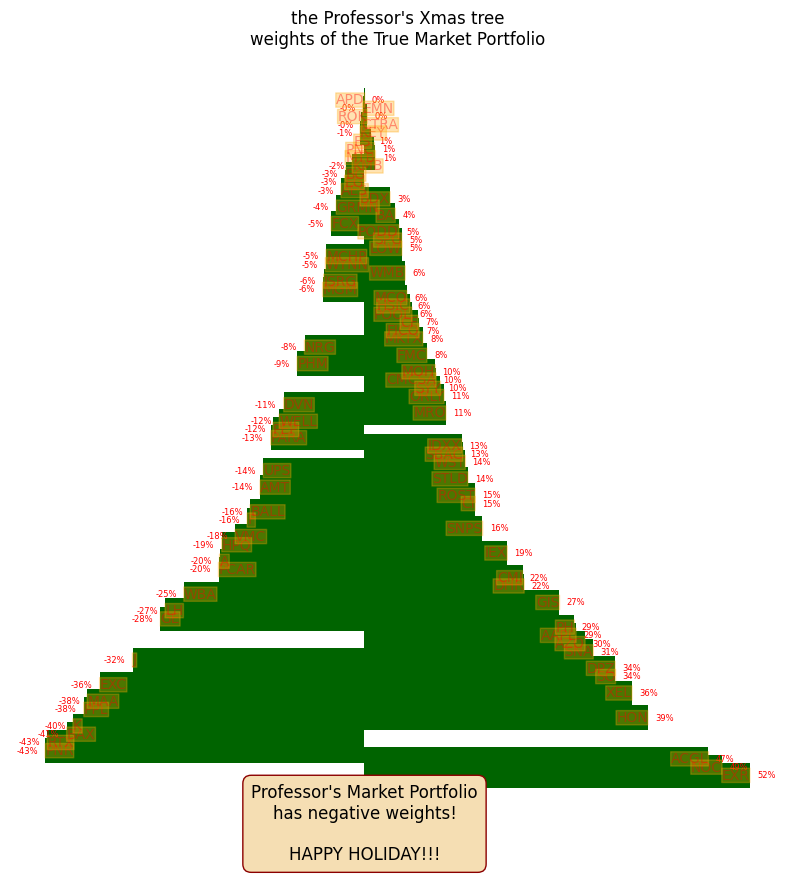

In [ ]:
from matplotlib.patches import FancyBboxPatch

xmas_tree = y_weights.reindex(y_weights.abs().sort_values().index).iloc[::-1]

fig, ax = plt.subplots(figsize=(10, 10))
bars = plt.barh(range(len(xmas_tree)), xmas_tree, color='darkgreen', height=3.0)

# Remove y-axis labels
plt.yticks([])
plt.xticks([])

# Display values as percentages in red next to each bar
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.01 if width > 0 else width - 0.01
    ha = 'left' if width > 0 else 'right'
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2,
             f'{width:.0%}', size= 6, ha=ha, va='center', color='red')

# Add index labels with rounded edges
# Add index labels with rounded edges
for i, (index, value) in enumerate(xmas_tree.items()):
    # Define the position for the label
    y = i
    x = value if value > 0 else value  # Adjust position based on bar direction
    ha = 'right' if value > 0 else 'left'

    # Create a rounded box
    bbox_props = dict(boxstyle="round,pad=0.01", edgecolor="orange", facecolor="orange", alpha=0.3, zorder=2)
    ax.text(x, y, index, ha=ha, va='center', bbox=bbox_props, color='red', alpha=0.4)


plt.text(0, -1, 'Professor\'s Market Portfolio\nhas negative weights!\n \nHAPPY HOLIDAY!!!', ha='center', va='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=1, edgecolor='darkred'),
         fontsize=12)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)

plt.title('the Professor\'s Xmas tree\nweights of the True Market Portfolio')

plt.show()


### Testing

In [ ]:
metrics_test = create_metrics(stock_close, test_start, forecast_end)
cov_matrix_test = stock_KPIs(stock_close, test_start, forecast_end)['cov_matrix']

In [ ]:
beta_test_df = calculate_betas_using_TMP(y_weights, cov_matrix_test, metrics_test, y_stats['var'])
beta_test_df

,mean_returns,variance,volatility,Beta
CI,0.007969,0.068513,0.261750,0.120458
PEP,-0.015751,0.024295,0.155867,0.029478
CMCSA,0.138547,0.052390,0.228888,-0.047210
WYNN,0.069562,0.089200,0.298663,-0.025292
PNC,0.133647,0.077822,0.278965,-0.107641
...,...,...,...,...
GRMN,0.432616,0.076208,0.276057,0.016341
APD,0.029234,0.076780,0.277091,-0.045544
WELL,0.402931,0.047013,0.216826,-0.049125
A,-0.043492,0.071087,0.266621,-0.040039


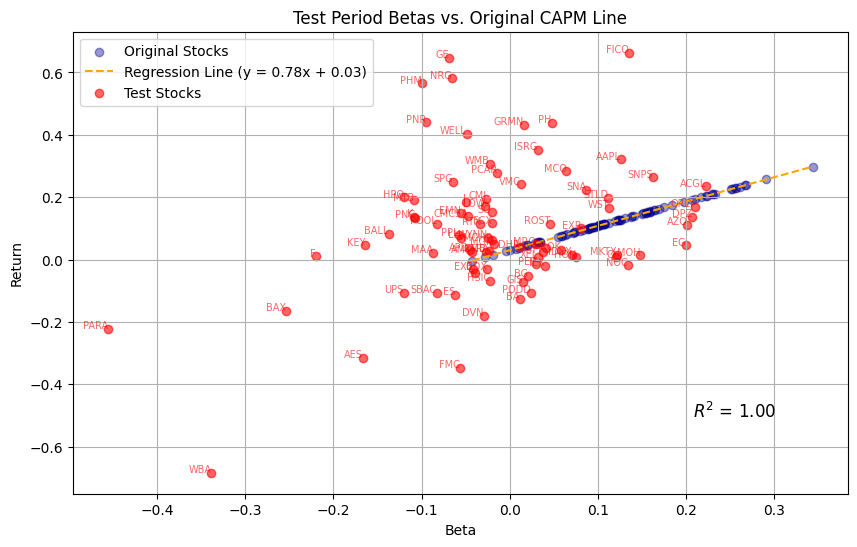

In [ ]:
# Define a range for x based on the min and max of beta_df['Beta']
x_range = np.linspace(beta_df['Beta'].min(), beta_df['Beta'].max(), 100)

# Calculate the regression line for this range
regression_line = slope * x_range + intercept

# Plot the original scatter plot and regression line
plt.figure(figsize=(10, 6))
plt.scatter(beta_df['Beta'], beta_df['mean_returns'], color='darkblue', alpha=0.4, label='Original Stocks')
plt.plot(x_range, regression_line, color='orange', linestyle='--', label=f'Regression Line (y = {slope:.2f}x + {intercept:.2f})')

# Overlay the new test betas on the same plot
plt.scatter(beta_test_df['Beta'], beta_test_df['mean_returns'], color='red', alpha=0.6, label='Test Stocks')

# Optional: add labels for test stocks
for ticker in beta_test_df.index:
    plt.text(beta_test_df.loc[ticker, 'Beta'], beta_test_df.loc[ticker, 'mean_returns'],
             ticker, color='red', fontsize=7, alpha=0.6, ha='right')

# Display R-squared value on the plot for the original data regression
plt.text(0.8, 0.2, f'$R^2$ = {r_value**2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# Set plot labels and title
plt.xlabel('Beta')
plt.ylabel('Return')
plt.title('Test Period Betas vs. Original CAPM Line')
plt.grid(True)
plt.legend()
plt.show()


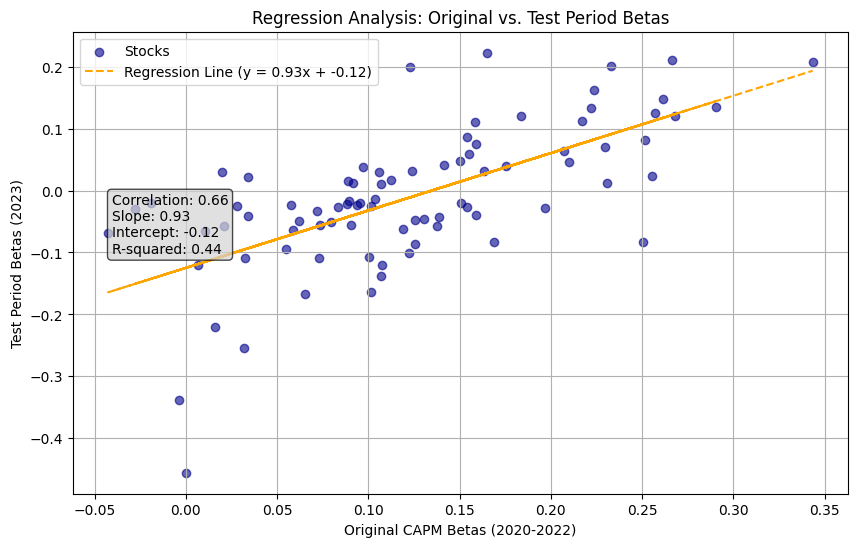

In [ ]:

# Step 1: Merge DataFrames on stock tickers
merged_betas = beta_df[['Beta']].merge(beta_test_df[['Beta']], left_index=True, right_index=True, suffixes=('_original', '_test'))

# Step 2: Calculate correlation between original and test period betas
correlation = merged_betas['Beta_original'].corr(merged_betas['Beta_test'])

# Step 3: Regression analysis (test betas on original betas)
slope, intercept, r_value, p_value, std_err = linregress(merged_betas['Beta_original'], merged_betas['Beta_test'])

# Step 4: Plot regression line and scatter plot for visual inspection
plt.figure(figsize=(10, 6))
plt.scatter(merged_betas['Beta_original'], merged_betas['Beta_test'], color='darkblue', alpha=0.6, label='Stocks')
plt.plot(merged_betas['Beta_original'], slope * merged_betas['Beta_original'] + intercept, color='orange', linestyle='--', label=f'Regression Line (y = {slope:.2f}x + {intercept:.2f})')

# Add text box with calculated statistics
textstr = (
    f"Correlation: {correlation:.2f}\n"
    f"Slope: {slope:.2f}\n"
    f"Intercept: {intercept:.2f}\n"
    f"R-squared: {r_value**2:.2f}"
)

# Position the text box on the plot
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.7)
plt.text(0.05, 0.65, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

# Set plot labels and title
plt.xlabel('Original CAPM Betas (2020-2022)')
plt.ylabel('Test Period Betas (2023)')
plt.title('Regression Analysis: Original vs. Test Period Betas')
plt.legend()
plt.grid(True)
plt.show()


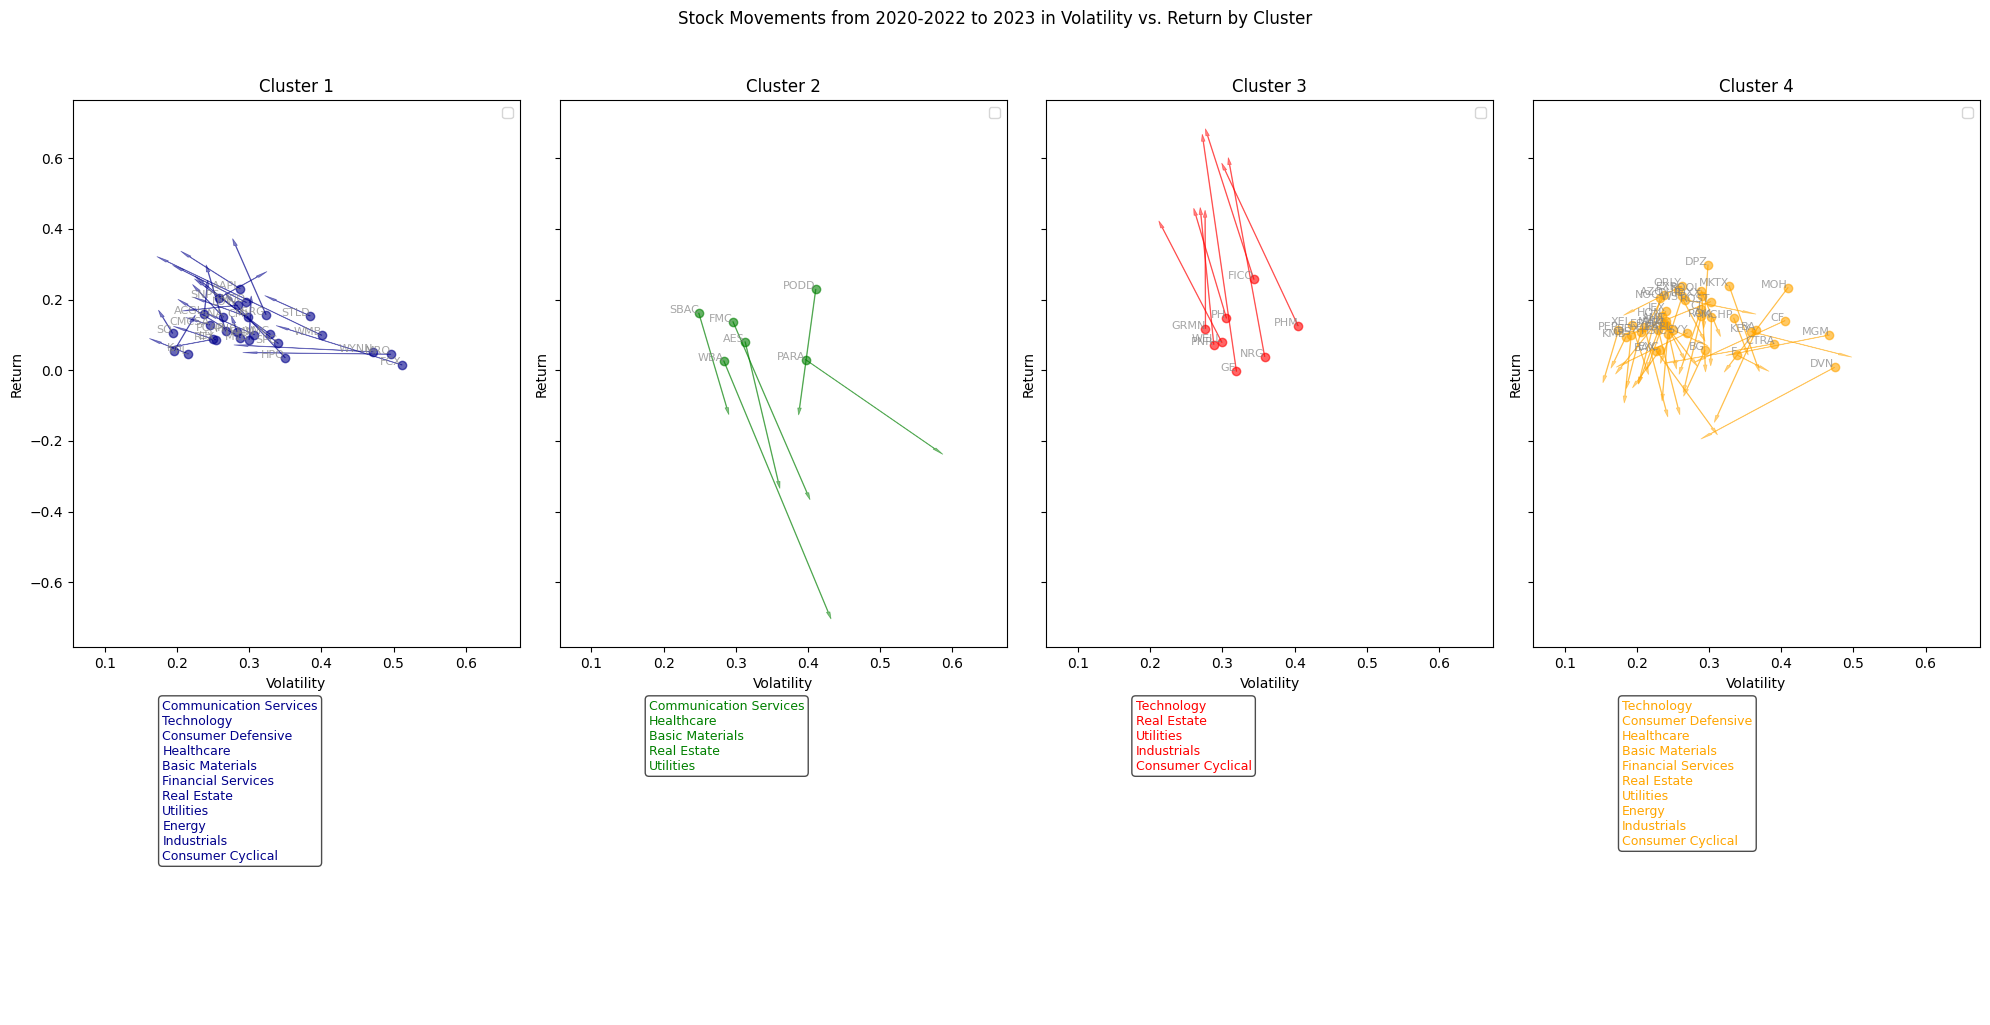

In [ ]:
# Step 1: Calculate movement vectors
movements = pd.DataFrame(index=beta_df.index)
movements['Δvolatility'] = beta_test_df['volatility'] - beta_df['volatility']
movements['Δreturn'] = beta_test_df['mean_returns'] - beta_df['mean_returns']

# Step 2: Cluster the movement vectors
kmeans = KMeans(n_clusters=4, random_state=0).fit(movements)
movements['Cluster'] = kmeans.labels_

# Define fixed colors for clusters
cluster_colors = {0: 'darkblue', 1: 'green', 2: 'red', 3: 'orange'}

# Determine consistent x and y limits
x_min = min(beta_df['volatility'].min(), beta_test_df['volatility'].min()-0.1)
x_max = max(beta_df['volatility'].max(), beta_test_df['volatility'].max()+0.1)
y_min = min(beta_df['mean_returns'].min(), beta_test_df['mean_returns'].min()-0.1)
y_max = max(beta_df['mean_returns'].max(), beta_test_df['mean_returns'].max()+0.1)

# Step 3: Set up a grid of subplots for each cluster
n_clusters = kmeans.n_clusters
fig, axes = plt.subplots(2, n_clusters, figsize=(5 * n_clusters, 10), gridspec_kw={'height_ratios': [2, 1]}, sharey=True)

# Plot each cluster in its own subplot (top row)
for cluster in range(n_clusters):
    ax = axes[0, cluster]  # Select the current axis for the cluster
    cluster_points = beta_df[movements['Cluster'] == cluster]

    # Set consistent axis limits
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Plot original points for this cluster
    ax.scatter(cluster_points['volatility'], cluster_points['mean_returns'], color=cluster_colors[cluster],
               alpha=0.6, label=f'Original (Cluster {cluster + 1})')

    # Add arrows showing movement from original to test period positions
    for ticker in cluster_points.index:
        ax.arrow(beta_df.loc[ticker, 'volatility'], beta_df.loc[ticker, 'mean_returns'],
                 movements.loc[ticker, 'Δvolatility'], movements.loc[ticker, 'Δreturn'],
                 color=cluster_colors[cluster], alpha=0.5, head_width=0.005, head_length=0.02, linewidth=0.5)
         # Label each stock with ticker
        ax.text(beta_df.loc[ticker, 'volatility'], beta_df.loc[ticker, 'mean_returns'], ticker,
                fontsize=8, alpha=0.7, color='grey', ha='right')

    # Set axis labels and title for each subplot
    ax.set_xlabel('Volatility')
    ax.set_ylabel('Return')
    ax.set_title(f'Cluster {cluster + 1}')
    ax.grid(False)
    ax.legend([])

    # Prepare unique industries for stocks in this cluster (bottom row)
    cluster_stocks = cluster_points.index
    unique_industries = set(companies_overview.loc[ticker, 'sector'] for ticker in cluster_stocks if ticker in companies_overview.index)
    industries_text = "\n".join(unique_industries)

    # Add text box below the chart (in bottom row subplot)
    text_ax = axes[1, cluster]
    text_ax.text(0.2, 1, industries_text, fontsize=9, verticalalignment='top', horizontalalignment='left',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.7), color=cluster_colors[cluster])
    text_ax.axis('off')  # Hide axes for the text box

# Adjust layout to fit titles and labels
plt.suptitle('Stock Movements from 2020-2022 to 2023 in Volatility vs. Return by Cluster', y=1.02)
plt.tight_layout()
plt.show()
